<a href="https://colab.research.google.com/github/amar-naik/EVA/blob/master/S5/S5_step5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

Target:

Put together all the elements of the model and see if accuracy is improving. Also checking results with and without LR in same code

Results :

Parameters: 9280

Without step LR
Best Train Accuracy: 96.91

Best Test Accuracy: 99.02


With step LR
Best Train Accuracy: 96.58

Best Test Accuracy: 99.01


Analysis:

Though the model is working there is  over-fitting as seen in the train/test for both with and wihtout LR

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [3]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


# Dataloader Arguments & Test/Train Dataloaders


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


# The model
Let's start with the model we first saw

In [0]:
import torch.nn.functional as F
dropout_val = 0.25

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.dropout_val = 0.25
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1, stride=1,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(32, 8, 3, padding=1, stride=1,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.MaxPool2d(2, 2),            
            nn.Dropout(self.dropout_val)
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(8, 8, 3, padding=1,stride=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(8, 16, 3, padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Dropout(self.dropout_val),

        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(16, 16, 3,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(self.dropout_val),
            nn.Conv2d(16, 16, 3,bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2, 2),
            nn.Dropout(self.dropout_val)
        )
        
        self.gap_linear = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Conv2d(16, 10, 1, bias=False)
        )
                
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        
        #x = x.view(x.size(0), -1)
        x = self.gap_linear(x)
        x = x.view(-1, 10)
        x = F.log_softmax(x, dim=1)
        return x

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [15]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             288
              ReLU-2           [-1, 32, 28, 28]               0
       BatchNorm2d-3           [-1, 32, 28, 28]              64
           Dropout-4           [-1, 32, 28, 28]               0
            Conv2d-5            [-1, 8, 28, 28]           2,304
              ReLU-6            [-1, 8, 28, 28]               0
       BatchNorm2d-7            [-1, 8, 28, 28]              16
         MaxPool2d-8            [-1, 8, 14, 14]               0
           Dropout-9            [-1, 8, 14, 14]               0
           Conv2d-10            [-1, 8, 14, 14]             576
             ReLU-11            [-1, 8, 14, 14]               0
      BatchNorm2d-12            [-1, 8, 14, 14]              16
          Dropout-13            [-1, 8, 14, 14]               0
           Conv2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [19]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
#scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    # scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.18585407733917236 Batch_id=468 Accuracy=81.22: 100%|██████████| 469/469 [00:14<00:00, 38.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0924, Accuracy: 9723/10000 (97.23%)

EPOCH: 1


Loss=0.2005380243062973 Batch_id=468 Accuracy=93.35: 100%|██████████| 469/469 [00:14<00:00, 33.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0616, Accuracy: 9817/10000 (98.17%)

EPOCH: 2


Loss=0.09523976594209671 Batch_id=468 Accuracy=94.88: 100%|██████████| 469/469 [00:14<00:00, 32.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0538, Accuracy: 9826/10000 (98.26%)

EPOCH: 3


Loss=0.25229397416114807 Batch_id=468 Accuracy=95.36: 100%|██████████| 469/469 [00:14<00:00, 32.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Accuracy: 9858/10000 (98.58%)

EPOCH: 4


Loss=0.11150181293487549 Batch_id=468 Accuracy=95.77: 100%|██████████| 469/469 [00:14<00:00, 32.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Accuracy: 9856/10000 (98.56%)

EPOCH: 5


Loss=0.24204210937023163 Batch_id=468 Accuracy=96.05: 100%|██████████| 469/469 [00:14<00:00, 33.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9882/10000 (98.82%)

EPOCH: 6


Loss=0.06378067284822464 Batch_id=468 Accuracy=96.25: 100%|██████████| 469/469 [00:14<00:00, 32.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0370, Accuracy: 9862/10000 (98.62%)

EPOCH: 7


Loss=0.14333780109882355 Batch_id=468 Accuracy=96.38: 100%|██████████| 469/469 [00:14<00:00, 33.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9866/10000 (98.66%)

EPOCH: 8


Loss=0.1233275756239891 Batch_id=468 Accuracy=96.41: 100%|██████████| 469/469 [00:13<00:00, 33.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9889/10000 (98.89%)

EPOCH: 9


Loss=0.10762280970811844 Batch_id=468 Accuracy=96.66: 100%|██████████| 469/469 [00:13<00:00, 33.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9891/10000 (98.91%)

EPOCH: 10


Loss=0.11582406610250473 Batch_id=468 Accuracy=96.69: 100%|██████████| 469/469 [00:14<00:00, 32.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9893/10000 (98.93%)

EPOCH: 11


Loss=0.14092810451984406 Batch_id=468 Accuracy=96.75: 100%|██████████| 469/469 [00:13<00:00, 33.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9887/10000 (98.87%)

EPOCH: 12


Loss=0.17109918594360352 Batch_id=468 Accuracy=96.91: 100%|██████████| 469/469 [00:13<00:00, 33.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9888/10000 (98.88%)

EPOCH: 13


Loss=0.08912806957960129 Batch_id=468 Accuracy=96.78: 100%|██████████| 469/469 [00:13<00:00, 34.16it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0293, Accuracy: 9894/10000 (98.94%)

EPOCH: 14


Loss=0.06584864109754562 Batch_id=468 Accuracy=96.97: 100%|██████████| 469/469 [00:14<00:00, 33.40it/s]



Test set: Average loss: 0.0292, Accuracy: 9902/10000 (99.02%)



# Let's Train and test our model



Text(0.5, 1.0, 'Test Accuracy')

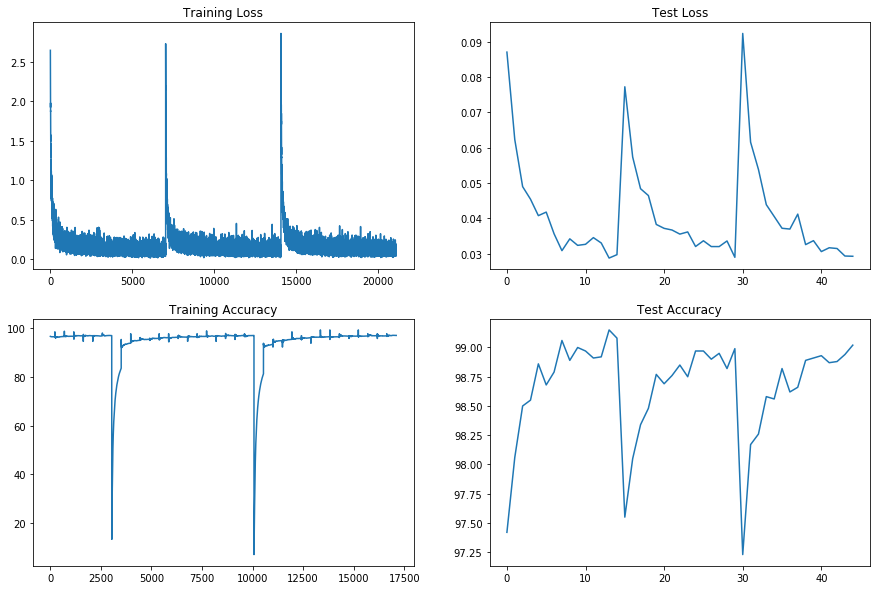

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [21]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.1)


EPOCHS = 15
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.3822334110736847 Batch_id=468 Accuracy=79.69: 100%|██████████| 469/469 [00:14<00:00, 33.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0909, Accuracy: 9734/10000 (97.34%)

EPOCH: 1


Loss=0.1491054892539978 Batch_id=468 Accuracy=93.11: 100%|██████████| 469/469 [00:13<00:00, 33.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0612, Accuracy: 9812/10000 (98.12%)

EPOCH: 2


Loss=0.22559769451618195 Batch_id=468 Accuracy=94.56: 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0484, Accuracy: 9840/10000 (98.40%)

EPOCH: 3


Loss=0.12982963025569916 Batch_id=468 Accuracy=95.20: 100%|██████████| 469/469 [00:13<00:00, 34.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Accuracy: 9868/10000 (98.68%)

EPOCH: 4


Loss=0.09394431859254837 Batch_id=468 Accuracy=95.54: 100%|██████████| 469/469 [00:13<00:00, 34.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0386, Accuracy: 9874/10000 (98.74%)

EPOCH: 5


Loss=0.10003998130559921 Batch_id=468 Accuracy=95.79: 100%|██████████| 469/469 [00:13<00:00, 34.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0343, Accuracy: 9876/10000 (98.76%)

EPOCH: 6


Loss=0.19921815395355225 Batch_id=468 Accuracy=96.18: 100%|██████████| 469/469 [00:13<00:00, 33.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9881/10000 (98.81%)

EPOCH: 7


Loss=0.058428261429071426 Batch_id=468 Accuracy=96.38: 100%|██████████| 469/469 [00:13<00:00, 34.38it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9894/10000 (98.94%)

EPOCH: 8


Loss=0.07520759850740433 Batch_id=468 Accuracy=96.38: 100%|██████████| 469/469 [00:13<00:00, 34.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0314, Accuracy: 9893/10000 (98.93%)

EPOCH: 9


Loss=0.07381565123796463 Batch_id=468 Accuracy=96.35: 100%|██████████| 469/469 [00:13<00:00, 34.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9890/10000 (98.90%)

EPOCH: 10


Loss=0.13008683919906616 Batch_id=468 Accuracy=96.37: 100%|██████████| 469/469 [00:13<00:00, 33.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9894/10000 (98.94%)

EPOCH: 11


Loss=0.11663947254419327 Batch_id=468 Accuracy=96.44: 100%|██████████| 469/469 [00:13<00:00, 34.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0307, Accuracy: 9898/10000 (98.98%)

EPOCH: 12


Loss=0.09316101670265198 Batch_id=468 Accuracy=96.58: 100%|██████████| 469/469 [00:13<00:00, 35.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9901/10000 (99.01%)

EPOCH: 13


Loss=0.04269471764564514 Batch_id=468 Accuracy=96.51: 100%|██████████| 469/469 [00:13<00:00, 34.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9900/10000 (99.00%)

EPOCH: 14


Loss=0.15238749980926514 Batch_id=468 Accuracy=96.55: 100%|██████████| 469/469 [00:14<00:00, 33.29it/s]



Test set: Average loss: 0.0300, Accuracy: 9899/10000 (98.99%)



In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")